In [4]:
###------Network Simulator------###
###------Shulin Cao------###
###------CMRG, UC San Diego------###

###import packages###
import pandas as pd
import collections
import timeit
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.mlab as mlab
import statistics
import random
import numpy.linalg
import numpy as np
import sys
from scipy.optimize import minimize
elapsed_time = timeit.default_timer()
from sklearn.linear_model import LinearRegression
from sklearn import cluster
import seaborn as sns
sns.set()
from sklearn import datasets
from sklearn.metrics import r2_score
from matplotlib import pylab
from matplotlib import font_manager
import chaospy as cp 
import uncertainpy as un
%matplotlib inline
chf = font_manager.FontProperties(fname='arial.ttf')
chf_v4 = font_manager.FontProperties(fname='arial.ttf', size = 25)

In [5]:
def get_reactors(reac):
    reac_split = reac.split(' ')
    reactors = []
    for k in reac_split:
        if k != '&' and k!= '=>':
            reactors.append(k)
    return reactors[:-1]


def Hill(reactor, n, EC50):
    B = (EC50**n-1)/(2*EC50**n-1)
    C = (B-1)**(1/n)
    if reactor[0] == '!':
        return (1-B*globals()['{}'.format(reactor[1:])]**n/(C**n + globals()['{}'.format(reactor[1:])]**n))
    else:
        return B*globals()['{}'.format(reactor)]**n/(C**n + globals()['{}'.format(reactor)]**n)


def OR(reaction_list):
    tera = (-1)**(len(reaction_list)+1)
    for k in reaction_list:
        weight, n, EC50 = reaction_list[k]
        final = weight
        for j in get_reactors(k):
            final *= Hill(j, n, EC50)
        tera *= (final-1)
    tera +=1
    return tera

In [6]:
def inte(state, t, reaction_dict):
    for i in range(len(node_ID)):
        globals()['{}'.format(node_ID[i])] = state[i]
    for i in range(len(node_ID)):
        if len(reaction_dict[node_ID[i]]) == 1:
            reactors = get_reactors(list(reaction_dict[node_ID[i]].keys())[0])
            weight, n, EC50 = reaction_dict[node_ID[i]][list(reaction_dict[node_ID[i]].keys())[0]]
            TF = 1
            for j in reactors:
                TF *= Hill(j, n, EC50)
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*weight*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
        else:
            TF = OR(reaction_dict[node_ID[i]])
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
    return [globals()['{}'.format(k+ 'd')] for k in node_ID]

In [7]:
reactions_raw = pd.read_excel('MTv29-philip-20170921-for-network.xlsx', sheet_name = 1, skiprows = 1, header = 0)
species_raw = pd.read_excel('MTv29-philip-20170921-for-network.xlsx', sheet_name = 0, skiprows = 1, header = 0)

In [8]:
species = species_raw[['ID', 'Yinit', 'Ymax', 'tau']]
node_ID = species['ID'].tolist()
Yinit = species['Yinit'].tolist()
Ymax = species['Ymax'].tolist()
tau = species['tau'].tolist()

In [9]:
species_dict = dict()
for k in range(len(species)):
    #lis = species.loc[k, ['Yinit', 'Ymax', 'tau']].tolist()
    species_dict[species.loc[k, 'ID']] = species.loc[k, ['Yinit', 'Ymax', 'tau']].tolist()

state0 = []
for k in range(len(node_ID)):
    state0.append(Yinit[k])  #solve_ivp

In [10]:
t = np.arange(0.0, 60.0*4, 0.1)
threshold = 0.05

In [11]:
validation = {}
validation['Stretch'] = {
    'aMHC':-1,
    'ANP':1,
    'Ao':1,
    'bMHC':1,
    'BNP':1,
    'CellArea':1,
    'PrSynth':1,
    'sACT':1,
    'SERCA':-1,
    'Akt':1,
    'AngII':1,
    'AP1':1,
    'Ca':1,
    'CaN':1,
    'cFos':1,
    'cJun':1,
    'cMyc':1,
    'CREB':1,
    'Cx43':1,
    'DAG':1,
    'EGFR':1,
    'ERK12':1,
    'FAK':1,
    'FHL1':1,
    'GATA4':1,
    'gp130':1,
    'GSK3b':-1,
    'IP3':1,
    'JAK':1,
    'JNK':1,
    'Lmcd1':1,
    'MEF2':1,
    'MEK12':1,
    'MLP':1,
    'MRTF':1,
    'mTor':1,
    'MuRF':-1,
    'NFAT':1,
    'NFkB':1,
    'NOS':1,
    'p38':1,
    'p70s6k':1,
    'PI3K':1,
    'PKC':1,
    'Rac1':1,
    'Raf1':1,
    'Ras':1,
    'RhoA':1,
    'RhoGEF':1,
    'Src':1,
    'SRF':1,
    'STAT':1
}
validation['Akt'] = {'ERK12':-1}
validation['AP1'] = {'BNP':0}
validation['AT1R'] = {
    'ANP':-1,
    'Ao':-1,
    'BNP':-1,
    'CellArea':-1,
    'cFos':-1,
    'cJun':0,
    'Cx43':-1,
    'ERK12':-1,
    'JNK':1,
    'Raf1':-1,
    'sACT':-1,
    'STAT':-1
}
validation['Ca'] = {
    'cFos':-1,
    'cJun':0,
    'STAT':-1
}
validation['CaN'] = {
    'ANP':-1
}
validation['EGFR'] = {
    'BNP':-1,
    'ERK12':-1,
    'JNK':0,
    'MEK12':-1,
    'Ras':-1
}
validation['ET1R'] = {
    'ANP':-1,
    'BNP':-1,
    'cFos':-1,
    'STAT':0
}
validation['FAK'] = {
    'Akt':-1,
    'ANP':-1,
    'bMHC':-1,
    'CellArea':-1,
    'cJun':-1,
    'cMyc':-1,
    'ERK12':-1,
    'JNK':1,
    'MEF2':-1,
    'mTor':-1,
    'p70s6k':-1,
    'Src':-1,
}
validation['Ga1213'] = {
    'RhoA':-1,
    'RhoGEF':-1
}
validation['GATA4'] = {
    'BNP':-1
}
validation['gp130'] = {
    'STAT':-1
}
validation['Integrin'] = {
    'ERK12':-1,
    'FAK':-1,
    'JNK':-1,
    'p38':-1,
    'RhoA':-1,
    'RhoGEF':-1
}
validation['JAK'] = {
    'STAT':-1
}
validation['JNK'] = {
    'ANP':-1,
    'Ao':1,
    'cJun':-1,
    'ERK12':-1
}
validation['Lmcd1'] = {
    'CellArea':-1
}
validation['LTCC'] = {
    'aMHC':-1,
    'ANP':-1,
    'bMHC':-1,
    'Ca':-1,
    'CaN':-1,
    'PrSynth':-1,
    'SERCA':0
}
validation['MEK12'] = {
    'BNP':-1,
    'Cx43':-1,
    'ERK12':-1
}
validation['MLP'] = {
    'BNP':-1,
    'NFAT':-1,
    'PrSynth':-1
}
validation['MRTF'] = {
    'bMHC':-1,
    'BNP':-1
}
validation['NCX'] = {
    'ANP':-1,
    'CaN':-1,
    'PrSynth':-1
}
validation['NHE'] = {
    'ANP':-1,
    'CaN':-1,
    'ERK12':-1,
    'PrSynth':-1,
    'Raf1':-1,
    'STAT':-1
}
validation['p38'] = {
    'Ao':-1,
    'PrSynth':-1
}
validation['PI3K'] = {
    'Akt':-1,
    'BNP':-1,
    'ERK12':-1,
    'JNK':0,
    'NOS':-1,
    'Ras':-1
}
validation['PKC'] = {
    'cFos':-1,
    'Cx43':0,
    'ERK12':-1,
    'Raf1':-1,
    'STAT':-1
}
validation['PLC'] = {
    'Ca':-1,
    'cFos':-1,
    'IP3':-1
}
validation['Rac1'] = {
    'ERK12':-1
}
validation['Raf1'] = {
    'ERK12':-1
}
validation['Ras'] = {
    'ERK12':0,
    'JNK':0,
    'MEK12':-1,
    'p38':-1
}
validation['RhoGEF'] = {
    'ANP':-1,
    'bMHC':-1,
    'CellArea':-1,
    'MRTF':-1,
    'RhoA':-1
}
validation['RhoA'] = {
    'Akt':-1,
    'ANP':-1,
    'bMHC':-1,
    'BNP':-1,
    'cFos':-1,
    'ERK12':-1,
    'FAK':-1,
    'MRTF':-1,
    'PrSynth':-1,
    'sACT':-1
}
validation['Src'] = {
    'ANP':-1,
    'FAK':-1,
    'p38':-1
}
validation['Titin'] = {
    'MuRF':1
}

In [15]:
def acc_val(simu_data, reaction_dict, threshold):
    s = 0
    s_all = 0
    s_stretch = 0
    s_all_stretch = 0
    summary = dict()
    for i in validation:
        if i == 'Stretch':
            summary[i] = {}
            for j in validation[i]:
                s_all += 1
                if i == 'Stretch':
                    s_all_stretch += 1
                if simu_data[2399, node_ID.index(j)] - simu_data[0, node_ID.index(j)] >= threshold \
                    and validation[i][j]==1:
                    s += 1
                    s_stretch += 1
                elif simu_data[2399, node_ID.index(j)] - simu_data[0, node_ID.index(j)] <= -threshold \
                    and validation[i][j]==-1:
                    s += 1
                    s_stretch += 1
                elif simu_data[2399, node_ID.index(j)] - simu_data[0, node_ID.index(j)] >= -threshold \
                    and simu_data[2399, node_ID.index(j)] - simu_data[0, node_ID.index(j)] <= threshold \
                    and validation[i][j]==0:
                    s += 1
                    s_stretch += 1
                else:
                    summary[i][j] = simu_data[2399, node_ID.index(j)] - simu_data[0, node_ID.index(j)]
        else:
            summary[i] = {}
            Ymax[node_ID.index(i)] = 0
            simu_data_change = odeint(inte, state0, t, args = (reaction_dict, ))
            Ymax[node_ID.index(i)] = 1
            for j in validation[i]:
                s_all += 1
                if simu_data_change[2399, node_ID.index(j)] - simu_data[2399, node_ID.index(j)] >= threshold \
                    and validation[i][j]==1:
                    s += 1
                elif simu_data_change[2399, node_ID.index(j)] - simu_data[2399, node_ID.index(j)] <= -threshold \
                    and validation[i][j]==-1:
                    s += 1
                elif simu_data_change[2399, node_ID.index(j)] - simu_data[2399, node_ID.index(j)] >= -threshold \
                    and simu_data_change[2399, node_ID.index(j)] - simu_data[2399, node_ID.index(j)] <= threshold \
                    and validation[i][j]==0:
                    s += 1
                else:
                    summary[i][j] = simu_data_change[2399, node_ID.index(j)] - simu_data[2399, node_ID.index(j)]
    return [s/s_all, summary]

In [13]:
reactions = {
    'rule':reactions_raw['rule'].tolist(), 
    'weight':reactions_raw['weight'].tolist(), 
    'n':reactions_raw['n'].tolist(), 
    'EC50':reactions_raw['EC50'].tolist()
}
reactions = pd.DataFrame(data = reactions)
reaction_dict = collections.defaultdict(dict)
for k in range(len(reactions)):
    node = reactions.loc[k, 'rule'].split(' ')
    reaction_dict[node[-1]][reactions.loc[k, 'rule']] = reactions.loc[k, ['weight', 'n', 'EC50']].tolist() 
reaction_dict['Stretch']['=> Stretch'] = [0.7, 1.4, 0.5]

In [16]:
simu_data = odeint(inte, state0, t, args = (reaction_dict, ))
accuracy = acc_val(simu_data, reaction_dict, threshold)

In [17]:
def get_relation(reac):
    split_reac = reac.split(' ')
    if len(split_reac) ==2:
        return ['Input', split_reac[1]]
    else:
        reactor = []
        for k in split_reac[:-2]:
            if k!= '&':
                reactor.append(getout_inhib(k))
        return [reactor, split_reac[-1]]
def getout_inhib(node):
    if node[0] == '!':
        return node[1:]
    else:
        return node

In [18]:
rules = reactions['rule'].tolist()
relationship = []
for k in rules:
    if get_relation(k)[0] == 'Input':
        relationship.append(tuple(get_relation(k)+[node_ID.index(get_relation(k)[1])]))
    else:
        for i in get_relation(k)[0]:
            relationship.append((i, get_relation(k)[1], node_ID.index(get_relation(k)[1])))

In [19]:
relationship_network = []
for k in rules:
    if get_relation(k)[0] == 'Input':
        relationship_network.append(tuple(get_relation(k)))
    else:
        for i in get_relation(k)[0]:
            relationship_network.append((i, get_relation(k)[1]))

In [20]:
NetworkA = nx.DiGraph()
NetworkA.add_nodes_from(node_ID)
NetworkA.add_edges_from(relationship_network)

In [21]:
summary = accuracy[1]
combine = set()
for i in summary:
    if summary[i] != {}:
        for j in summary[i]:
            combine.add(i+'_'+j)

In [22]:
no_path = []
overall = dict()
for i in validation:
    for j in validation[i]:
        paths_between_generator_ = nx.all_simple_paths(NetworkA, source = i, target = j)
        nodes_between_set = {node for path in paths_between_generator_ for node in path}
        if i != 'Stretch':
            if len(nodes_between_set) != 0:
                overall[i+'_'+j] = len(nx.shortest_path(NetworkA, source = i, target = j))
            else:
                no_path.append(i+'_'+j)

In [23]:
correct_pre = []
wrong_change_unchange = []
wrong_unchange_change = []
correct_change = []
correct_unchange = []
for i in overall:
    if i in combine:
        m = i.split('_')
        if validation[m[0]][m[1]] == 0:
            wrong_change_unchange.append(overall[i])
        else:
            wrong_unchange_change.append(overall[i])
    else:
        m = i.split('_')
        if validation[m[0]][m[1]] == 0:
            correct_unchange.append(overall[i])
        else:
            correct_change.append(overall[i])
        correct_pre.append(overall[i])

In [25]:
NC_NC = collections.Counter(correct_unchange)
DE_DE = collections.Counter(correct_change)
NC_DE = collections.Counter(wrong_change_unchange)
DE_NC = collections.Counter(wrong_unchange_change)
compare_plot = pd.DataFrame(columns=['Pathway_Length', 
                                     'Expr NC/Model NC', 
                                     'Expr DE/Model DE',
                                     'Expr NC/Model DE', 
                                     'Expr DE/Model NC'])
for i in range(14):
    compare_plot.loc[len(compare_plot)] = [i, 
                                           NC_NC.get(i,0), 
                                           DE_DE.get(i,0), 
                                           -NC_DE.get(i,0), 
                                           -DE_NC.get(i,0)
                                          ]

In [26]:
compare_plot['Correct'] = compare_plot['Expr NC/Model NC']+compare_plot['Expr DE/Model DE']
compare_plot['Wrong'] = compare_plot['Expr NC/Model DE']+compare_plot['Expr DE/Model NC']

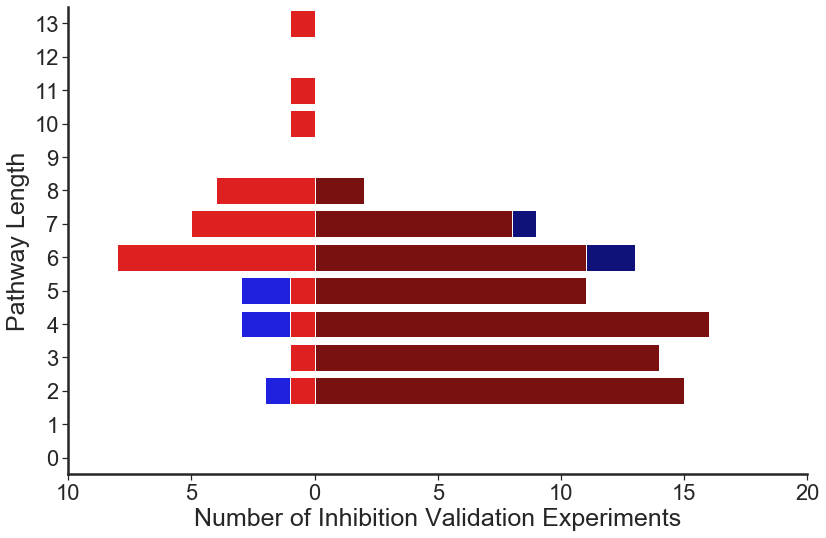

In [28]:
sns.set(font_scale=2)
sns.set_context(rc={"lines.linewidth": 5})
sns.set_style("ticks", {'axes.grid' : False, 'font.sans-serif':'Arial'})
plt.figure(figsize = (12,8))
ax = sns.barplot(x="Correct", 
                       y="Pathway_Length", 
                       color="darkblue", 
                       label="Expr NC/Model NC", 
                       data = compare_plot, 
                       orient='h'
                      )
ax = sns.barplot(x="Expr DE/Model DE", 
                       y="Pathway_Length", 
                       color="darkred", 
                       label="Expr DE/Model DE", 
                       data = compare_plot, 
                       orient='h'
                      )
ax = sns.barplot(x="Wrong", 
                       y="Pathway_Length", 
                       color="blue", 
                       label="Expr NC/Model DE", 
                       data = compare_plot, 
                       orient='h'
                      )
ax = sns.barplot(x="Expr DE/Model NC", 
                       y="Pathway_Length", 
                       color="red", 
                       label="Expr DE/Model NC", 
                       data = compare_plot, 
                       orient='h'
                      )
#pylab.legend(loc=9, bbox_to_anchor=(0.5, -0.12), ncol=2, fontsize=20, frameon=False)
plt.gca().invert_yaxis()
plt.xticks(np.array([-10, -5, 0, 5, 10, 15, 20]), ('10', '5', '0', '5', '10', '15', '20'))
plt.yticks(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]), 
           ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13'))
plt.ylabel('Pathway Length', fontproperties = chf_v4)
plt.xlabel('Number of Inhibition Validation Experiments', fontproperties = chf_v4)
sns.despine()
plt.tight_layout()
ax.spines['bottom'].set_linewidth(2.5)
ax.spines['left'].set_linewidth(2.5)
#plt.savefig('Fig5C.pdf', dpi=600)
plt.show()